# Topic Modelling

In [ ]:
pip install -r requirement.txt

In [1]:
from lda_gensim_modularized import *

In [2]:
from platform import python_version
print(python_version())

3.10.4


In [3]:
# Read in cleaned reviews
df_path = '../data/curated/reviews/cleaned_reviews.csv'
clean_data = read_data(df_path)

In [4]:
# obtain tfidf corpus
data = combine_reviews_to_list(clean_data)
data_words, id2word, bow_corpus = obtain_corpus(data)
corpus_tfidf = get_tfidf_corpus(bow_corpus)

In [6]:
# run LDA baseline model
lda_base_model = load_base_lda_model(data_words, id2word, corpus_tfidf)

Baseline Coherence Score:  0.3741965329013099


Num Topics = 2  has Coherence Value of 0.3581
Num Topics = 3  has Coherence Value of 0.6331
Num Topics = 4  has Coherence Value of 0.5661
Num Topics = 5  has Coherence Value of 0.5663
Num Topics = 6  has Coherence Value of 0.5549
Num Topics = 7  has Coherence Value of 0.5671
Num Topics = 8  has Coherence Value of 0.5543
Num Topics = 9  has Coherence Value of 0.5358


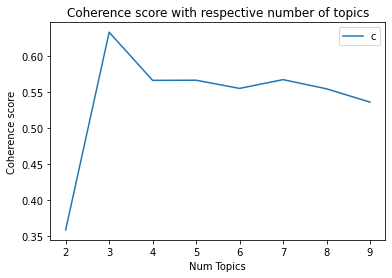

In [5]:
# Obtain optimal number of topics
final_num_topics, final_score, coherence_score_topic = get_coherence_values_and_optimal_topic_num(corpus_tfidf,10, id2word, data_words)

In [7]:
# run final LDA model using optimal number of topics
lda_final_model = load_final_lda_model(id2word, corpus_tfidf, final_num_topics)

# print 10 keywords of the topics
unique_sets(lda_final_model)

Topic: 0 
Words: 0.006*"coffee" + 0.004*"tea" + 0.004*"cup" + 0.003*"price" + 0.003*"love" + 0.003*"buy" + 0.003*"much" + 0.003*"chocolate" + 0.003*"try" + 0.003*"really"
Topic: 1 
Words: 0.003*"love" + 0.003*"snack" + 0.003*"bar" + 0.003*"price" + 0.003*"chip" + 0.003*"buy" + 0.003*"find" + 0.003*"try" + 0.003*"eat" + 0.003*"would"
Topic: 2 
Words: 0.004*"dog" + 0.004*"tea" + 0.003*"treat" + 0.003*"food" + 0.002*"love" + 0.002*"buy" + 0.002*"coffee" + 0.002*"cat" + 0.002*"eat" + 0.002*"china"
Topic 0: {'really', 'cup', 'much', 'chocolate'}
Topic 1: {'find', 'snack', 'bar', 'would', 'chip'}
Topic 2: {'dog', 'china', 'cat', 'food', 'treat'}


In [8]:
# Obtain the dominant topic for each review and save it to csv
topic_review_df = dominant_topic_per_review(lda_final_model, corpus_tfidf, data)

# topic distribution 
topic_distri_across_review(topic_review_df)

0    2456
1    2235
2     753
Name: Dominant_Topic, dtype: int64

# Topic Classification

In [9]:
from topic_classification_modularized import *

In [10]:
train, test = split_test_train(topic_review_df)

In [11]:
# Obtain train and test corpus respectively using LDA dictionary aka id2words 
x_train_corpus = preprocess_test_train(train, id2word)
x_test_corpus = preprocess_test_train(test, id2word)

In [12]:
y_train, y_test = y_label(train, test)

In [13]:
# Convert corpus to vectors to feed into sklearn
train_vecs = create_vectors(x_train_corpus, train, lda_final_model, final_num_topics)
test_vecs = create_vectors(x_test_corpus, test, lda_final_model, final_num_topics)

In [14]:
# Convert vector to scaled numpy array
x_train_scale, y_train, x_test_scale, y_test = convert_vector_to_scaled_array(train_vecs, y_train, test_vecs, y_test)

In [16]:
# Baseline svc
base_svc = baseline_svc(x_train_scale, y_train)

classification_df, confusion_matrix_df = predict_and_evaluate_model(base_svc, x_test_scale, y_test)
print(classification_df, confusion_matrix_df)

              precision    recall  f1-score      support
0              0.948025  0.940206  0.944099   485.000000
1              0.970320  0.948661  0.959368   448.000000
2              0.788235  0.858974  0.822086   156.000000
accuracy       0.932048  0.932048  0.932048     0.932048
macro avg      0.902193  0.915947  0.908518  1089.000000
weighted avg   0.934307  0.932048  0.932902  1089.000000      0    1    2
0  456    7   22
1    9  425   14
2   16    6  134


In [18]:
tune_hyperparameter(x_train_scale, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.3s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.3s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.4s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.4s
[CV] END ...................

[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ...................

In [19]:
# Final svc
svc_final =  final_svc(x_train_scale, y_train,  0.1,  0.01, 'sigmoid')

classification_df, confusion_matrix_df = predict_and_evaluate_model(svc_final, x_test_scale, y_test)
print(classification_df, confusion_matrix_df)

              precision    recall  f1-score      support
0              0.977413  0.981443  0.979424   485.000000
1              0.973626  0.988839  0.981174   448.000000
2              0.979592  0.923077  0.950495   156.000000
accuracy       0.976125  0.976125  0.976125     0.976125
macro avg      0.976877  0.964453  0.970364  1089.000000
weighted avg   0.976167  0.976125  0.976000  1089.000000      0    1    2
0  476    7    2
1    4  443    1
2    7    5  144
